In [68]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from keras import layers, models
from keras_tuner import HyperParameters
from keras_tuner import GridSearch
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import ReduceLROnPlateau

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

In [107]:
arff_file = arff.loadarff('./dataset_31_credit-g.arff')
df = pd.DataFrame(arff_file[0])
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,b'<0',6.0,b'critical/other existing credit',b'radio/tv',1169.0,b'no known savings',b'>=7',4.0,b'male single',b'none',...,b'real estate',67.0,b'none',b'own',2.0,b'skilled',1.0,b'yes',b'yes',b'good'
1,b'0<=X<200',48.0,b'existing paid',b'radio/tv',5951.0,b'<100',b'1<=X<4',2.0,b'female div/dep/mar',b'none',...,b'real estate',22.0,b'none',b'own',1.0,b'skilled',1.0,b'none',b'yes',b'bad'
2,b'no checking',12.0,b'critical/other existing credit',b'education',2096.0,b'<100',b'4<=X<7',2.0,b'male single',b'none',...,b'real estate',49.0,b'none',b'own',1.0,b'unskilled resident',2.0,b'none',b'yes',b'good'
3,b'<0',42.0,b'existing paid',b'furniture/equipment',7882.0,b'<100',b'4<=X<7',2.0,b'male single',b'guarantor',...,b'life insurance',45.0,b'none',b'for free',1.0,b'skilled',2.0,b'none',b'yes',b'good'
4,b'<0',24.0,b'delayed previously',b'new car',4870.0,b'<100',b'1<=X<4',3.0,b'male single',b'none',...,b'no known property',53.0,b'none',b'for free',2.0,b'skilled',2.0,b'none',b'yes',b'bad'


## Preprocessing

In [108]:
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

In [114]:
ordinal_columns = [
    "checking_status",
    "savings_status",
    "employment",
]

nominal_columns = [
    "credit_history",
    "purpose",
    "property_magnitude",
    "other_payment_plans",
    "housing",
]

numeric_columns = [
    "age",
    "duration",
    "credit_amount"
]

preprocessor = ColumnTransformer(
    transformers=[
        (
            'process_nominal_columns',
            Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]),
            nominal_columns
        ),
        (
            'process_ordinal_columns',
            Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OrdinalEncoder())
            ]),
            ordinal_columns
        ),
        (
            'process_numeric_columns',
            Pipeline(steps=[
                ('nan_imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]),
            numeric_columns
        ),
    ]
)

In [110]:
y = (df['class'] == 'good').astype(int) # Binary encoding for target
X = preprocessor.fit_transform(df)
X.shape

(1000, 31)

## Model building

In [111]:
class CNNHyperModel:
    def __init__(self, nb_features):
        self.nb_features = nb_features

    def build(self, hp: HyperParameters):

        dense_start = hp.Choice('dense_start', values=[32, 64, 128, 512, 1024])
        dropout = hp.Choice('dropout', values=[0.25, 0.5])
        l2_reg = hp.Choice('l2_regularization', values=[0.01, 0.001])
        learning_rate = 0.001

        model = models.Sequential()

        model.add(layers.Dense(dense_start, input_dim=self.nb_features, activation='relu', kernel_regularizer=l2(l2_reg)))
        model.add(layers.Dropout(dropout))
        model.add(layers.Dense(int(dense_start / 2), activation='relu', kernel_regularizer=l2(l2_reg)))
        model.add(layers.Dropout(dropout))
        model.add(layers.Dense(1, input_dim=self.nb_features, activation='sigmoid'))

        sgd = SGD(learning_rate=learning_rate, nesterov=True, momentum=0.9)
        model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

        return model

In [112]:
# split data into train, val, and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


print(f'Training rows: {len(X_train)}')
print(f'Validation rows: {len(X_val)}')

# use a callback to reduce the learning rate dynamically based on validation performance

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # Metric to monitor
    factor=0.5,                # Factor to reduce the learning rate
    patience=3,                # Number of epochs with no improvement before reduction
    min_lr=1e-6                # Minimum learning rate
)

hypermodel = CNNHyperModel(nb_features=X.shape[1])

tuner = GridSearch(
    hypermodel.build,
    objective='val_accuracy',
    executions_per_trial=5,
    directory='search',
    project_name='cnn',
    overwrite=True,
    seed=42
)

Training rows: 600
Validation rows: 200


/Users/chanlee/.pyenv/versions/3.11.2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [113]:
# Search for best parameters
tuner.search(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr]
)

tuner.results_summary()

Trial 20 Complete [00h 00m 15s]
val_accuracy: 0.6919999957084656

Best val_accuracy So Far: 0.7049999952316284
Total elapsed time: 00h 03m 36s
Results summary
Results in search/cnn
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0011 summary
Hyperparameters:
dense_start: 128
dropout: 0.5
l2_regularization: 0.001
Score: 0.7049999952316284

Trial 0002 summary
Hyperparameters:
dense_start: 32
dropout: 0.5
l2_regularization: 0.01
Score: 0.7009999990463257

Trial 0005 summary
Hyperparameters:
dense_start: 64
dropout: 0.25
l2_regularization: 0.001
Score: 0.6990000009536743

Trial 0008 summary
Hyperparameters:
dense_start: 128
dropout: 0.25
l2_regularization: 0.01
Score: 0.6990000009536743

Trial 0000 summary
Hyperparameters:
dense_start: 32
dropout: 0.25
l2_regularization: 0.01
Score: 0.696999990940094

Trial 0004 summary
Hyperparameters:
dense_start: 64
dropout: 0.25
l2_regularization: 0.01
Score: 0.6959999918937683

Trial 0007 summary
Hyperparameters:
dense_st

In [116]:
[ best_model ] = tuner.get_best_models(num_models=1)

/Users/chanlee/.pyenv/versions/3.11.2/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Evaluation on test data

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
CNN
	Accuracy: 0.67
	Precision: 0.7329192546583851
	Recall: 0.8368794326241135
	TPR: 0.8368794326241135
	FPR: 0.7288135593220338


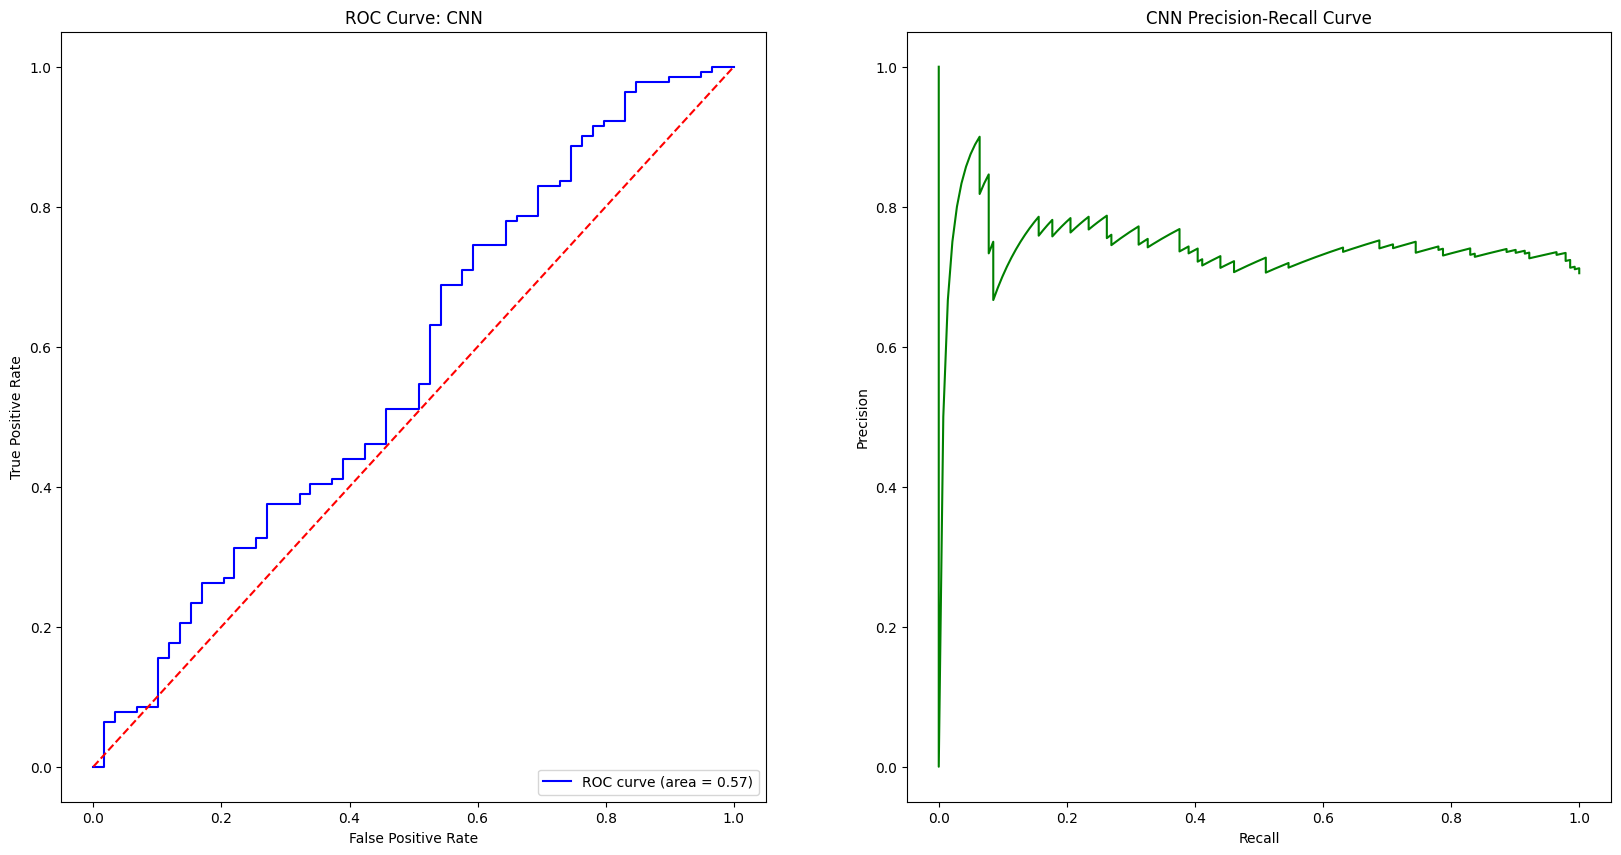

In [126]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import helpers as _helpers

# Evaluate on the validation set

y_proba = best_model.predict(X_test)
y_pred = (y_proba > 0.5).astype(int)

plt.figure(figsize=(20, 10))
_helpers.display_metrics('CNN', y_test, y_pred, y_proba)

In [128]:
from sklearn.metrics import confusion_matrix

# Cost matrix
cost_fp = 5  # Cost of a False Positive
cost_fn = 1  # Cost of a False Negative

# Assuming y_test (true labels) and y_pred (predicted labels) are defined
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

total_cost = (fp * cost_fp) + (fn * cost_fn)

print(f"Total Cost: {total_cost}")

Total Cost: 238
